Import Libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import r2_score, mean_squared_error, accuracy_score, f1_score, classification_report
from sklearn.preprocessing import StandardScaler

import warnings
warnings.filterwarnings('ignore')

Load Dataset

In [ ]:
df = pd.read_csv("Global_Pollution_Analysis.csv")

print(df.head())
print(df.info())

        Country  Year  Air_Pollution_Index  Water_Pollution_Index  \
0       Hungary  2005               272.70                 124.27   
1     Singapore  2001                86.72                  60.34   
2       Romania  2016                91.59                  83.36   
3  Cook Islands  2018               280.61                  67.16   
4      Djibouti  2008               179.16                 127.53   

   Soil_Pollution_Index  Industrial_Waste (in tons)  \
0                 51.95                    94802.83   
1                117.22                    56283.92   
2                121.72                    56256.02   
3                 93.58                    74864.73   
4                121.55                    76862.06   

   Energy_Recovered (in GWh)  CO2_Emissions (in MT)  Renewable_Energy (%)  \
0                     158.14                   5.30                 41.11   
1                     498.04                   6.34                 36.44   
2                     4

Basic Data Cleaning

In [ ]:
# Check missing values
print(df.isnull().sum())

# Drop missing values if any
df = df.dropna()

# Ensure correct sorting
df = df.sort_values(by=['Country', 'Year'])

Country                                   0
Year                                      0
Air_Pollution_Index                       0
Water_Pollution_Index                     0
Soil_Pollution_Index                      0
Industrial_Waste (in tons)                0
Energy_Recovered (in GWh)                 0
CO2_Emissions (in MT)                     0
Renewable_Energy (%)                      0
Plastic_Waste_Produced (in tons)          0
Energy_Consumption_Per_Capita (in MWh)    0
Population (in millions)                  0
GDP_Per_Capita (in USD)                   0
dtype: int64


================================
## ADVANCED EXPLORATORY DATA ANALYSIS
================================

Correlation Heatmap (Numeric Only)

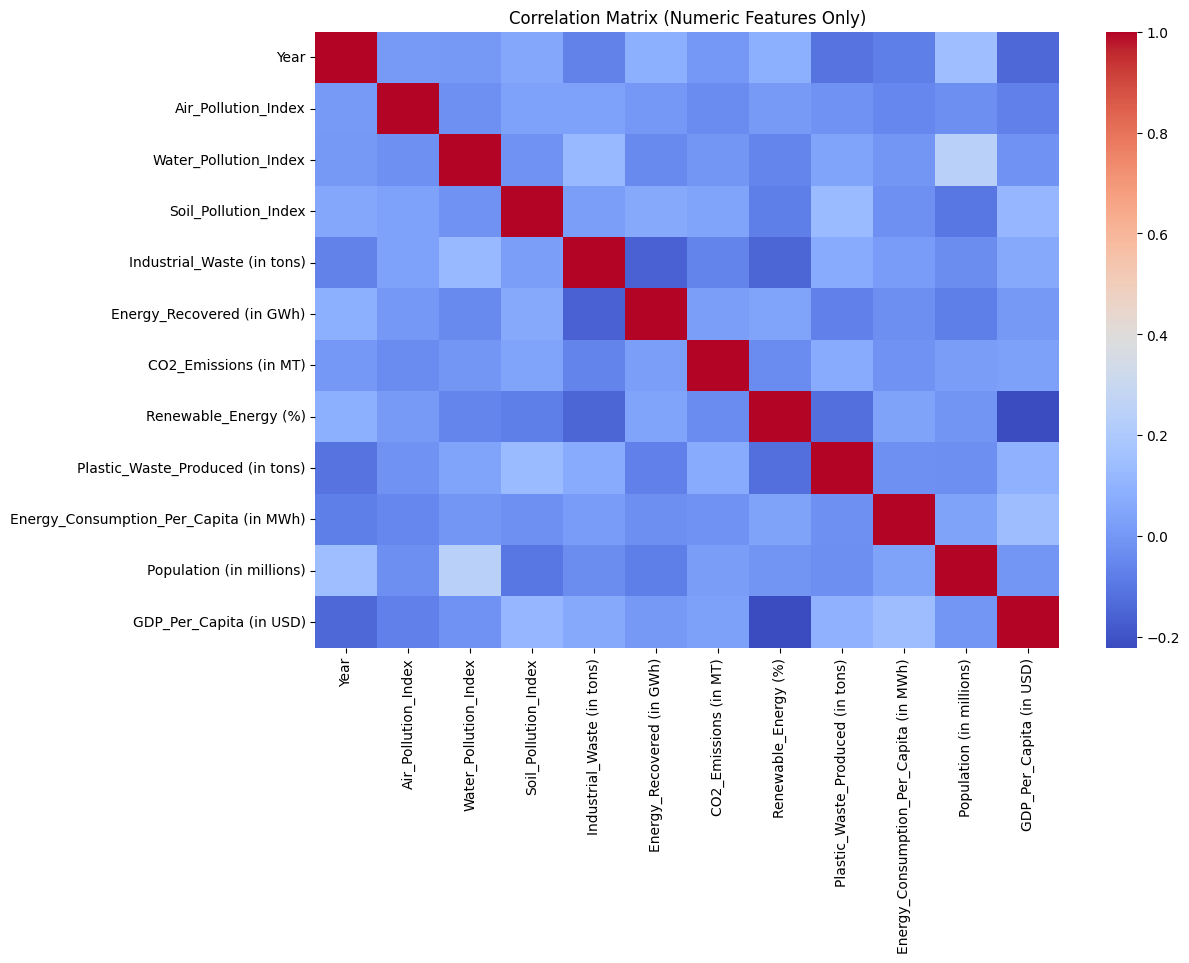

In [ ]:
numeric_df = df.select_dtypes(include=[np.number])

plt.figure(figsize=(12,8))
sns.heatmap(numeric_df.corr(), cmap='coolwarm')
plt.title("Correlation Matrix (Numeric Features Only)")
plt.show()

Country-wise CO₂ Multi-Year Trend

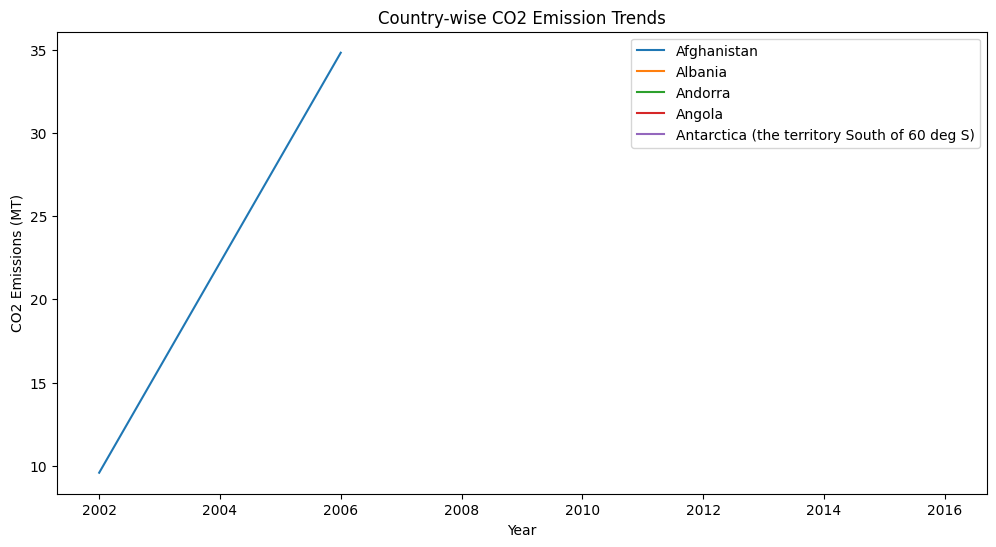

In [ ]:
plt.figure(figsize=(12,6))

top_countries = df['Country'].unique()[:5]

for country in top_countries:
    country_data = df[df['Country'] == country]
    plt.plot(country_data['Year'],
             country_data['CO2_Emissions (in MT)'],
             label=country)

plt.title("Country-wise CO2 Emission Trends")
plt.xlabel("Year")
plt.ylabel("CO2 Emissions (MT)")
plt.legend()
plt.show()

Rolling 3-Year CO₂ Trend

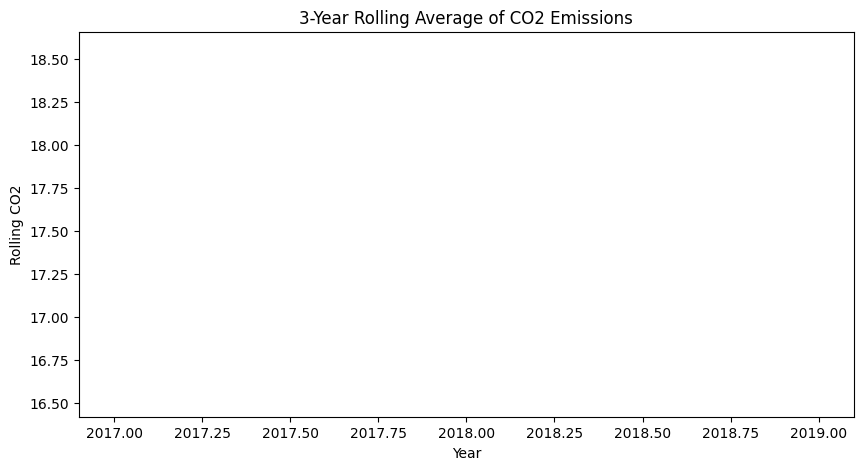

In [ ]:
df['CO2_Rolling_3yr'] = df.groupby('Country')['CO2_Emissions (in MT)']\
                            .transform(lambda x: x.rolling(3).mean())

plt.figure(figsize=(10,5))
plt.plot(df.groupby('Year')['CO2_Rolling_3yr'].mean())
plt.title("3-Year Rolling Average of CO2 Emissions")
plt.xlabel("Year")
plt.ylabel("Rolling CO2")
plt.show()

Multi-Variable Combined Trend

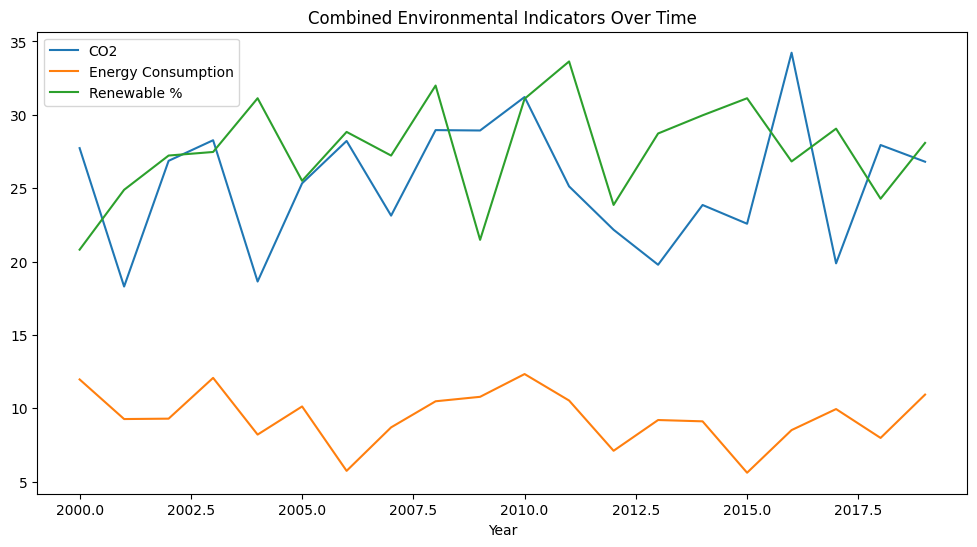

In [ ]:
yearly_avg = df.groupby('Year').mean(numeric_only=True)

plt.figure(figsize=(12,6))
plt.plot(yearly_avg.index, yearly_avg['CO2_Emissions (in MT)'], label='CO2')
plt.plot(yearly_avg.index, yearly_avg['Energy_Consumption_Per_Capita (in MWh)'], label='Energy Consumption')
plt.plot(yearly_avg.index, yearly_avg['Renewable_Energy (%)'], label='Renewable %')

plt.legend()
plt.title("Combined Environmental Indicators Over Time")
plt.xlabel("Year")
plt.show()

================================
## FEATURE ENGINEERING
================================

Interaction Features

In [ ]:
df['Waste_Energy_Interaction'] = df['Industrial_Waste (in tons)'] * df['Energy_Consumption_Per_Capita (in MWh)']

df['GDP_Energy_Interaction'] = df['GDP_Per_Capita (in USD)'] * df['Energy_Consumption_Per_Capita (in MWh)']

================================
## LINEAR REGRESSION (CO2 Prediction)
================================

Define Features & Target

In [ ]:
features = [
    'Air_Pollution_Index',
    'Water_Pollution_Index',
    'Soil_Pollution_Index',
    'Industrial_Waste (in tons)',
    'Energy_Recovered (in GWh)',
    'Renewable_Energy (%)',
    'Energy_Consumption_Per_Capita (in MWh)',
    'Population (in millions)',
    'GDP_Per_Capita (in USD)',
    'Waste_Energy_Interaction',
    'GDP_Energy_Interaction'
]

X = df[features]
y = df['CO2_Emissions (in MT)']

Train-Test Split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

Train Linear Model

In [ ]:
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)

y_pred = linear_model.predict(X_test)

print("Linear Regression R2:", r2_score(y_test, y_pred))
print("Linear Regression RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))

Linear Regression R2: -0.2737233300314532
Linear Regression RMSE: 14.089871429035576


Coefficient Interpretation Table

In [ ]:
coefficients = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': linear_model.coef_
}).sort_values(by='Coefficient', ascending=False)

print(coefficients)

                                   Feature  Coefficient
6   Energy_Consumption_Per_Capita (in MWh)     1.331156
2                     Soil_Pollution_Index     0.016919
7                 Population (in millions)     0.015804
4                Energy_Recovered (in GWh)     0.000630
8                  GDP_Per_Capita (in USD)     0.000229
3               Industrial_Waste (in tons)     0.000064
9                 Waste_Energy_Interaction    -0.000011
10                  GDP_Energy_Interaction    -0.000022
0                      Air_Pollution_Index    -0.006679
1                    Water_Pollution_Index    -0.010895
5                     Renewable_Energy (%)    -0.017687


================================
### LOGISTIC REGRESSION (High Pollution Classification)
================================

Create Binary Target

In [ ]:
threshold = df['CO2_Emissions (in MT)'].median()

df['High_CO2'] = (df['CO2_Emissions (in MT)'] > threshold).astype(int)

X_class = df[features]
y_class = df['High_CO2']

Scale Features

In [ ]:
scaler = StandardScaler()
X_class_scaled = scaler.fit_transform(X_class)

X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(
    X_class_scaled, y_class, test_size=0.2, random_state=42
)

Train Logistic Model

In [ ]:
log_model = LogisticRegression(max_iter=1000)
log_model.fit(X_train_c, y_train_c)

y_pred_class = log_model.predict(X_test_c)

print("Logistic Accuracy:", accuracy_score(y_test_c, y_pred_class))
print("Logistic F1 Score:", f1_score(y_test_c, y_pred_class))
print(classification_report(y_test_c, y_pred_class))

Logistic Accuracy: 0.425
Logistic F1 Score: 0.46511627906976744
              precision    recall  f1-score   support

           0       0.35      0.41      0.38        17
           1       0.50      0.43      0.47        23

    accuracy                           0.42        40
   macro avg       0.42      0.42      0.42        40
weighted avg       0.44      0.42      0.43        40



================================
### MODEL COMPARISON VISUAL
================================

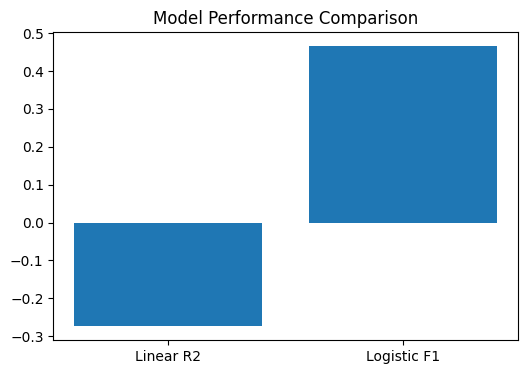

In [ ]:
models = ['Linear R2', 'Logistic F1']
scores = [
    r2_score(y_test, y_pred),
    f1_score(y_test_c, y_pred_class)
]

plt.figure(figsize=(6,4))
plt.bar(models, scores)
plt.title("Model Performance Comparison")
plt.show()

# Actionable Insights


1.   Energy Consumption shows strong positive influence on CO2 emissions.
2.   Industrial Waste significantly contributes to emission growth.
3.   Renewable Energy percentage negatively correlates with CO2.
4.   Logistic model can serve as an early warning system for high-emission years.
5.   Interaction terms suggest economic growth combined with energy usage accelerates emissions.




## Final Conclusion



*   Multi-year analysis reveals upward emission trends linked to energy growth.
*   Rolling averages indicate structural changes rather than short-term fluctuations.
*   Linear regression confirms key emission drivers.
*   Logistic regression supports pollution risk classification.
*   Renewable energy expansion is critical for emission mitigation.

